In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adnimerge = pd.read_csv('ADNIMERGE_06Feb2025.csv')
adnimerge.head()

C:\Users\anisr\AppData\Local\Temp\ipykernel_20356\3310966124.py:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  adnimerge = pd.read_csv('ADNIMERGE_06Feb2025.csv')


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.33615,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.498289,5.96721,6,6,2023-07-07 04:59:40.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.999316,11.96720,12,12,2023-07-07 04:59:40.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,1.998630,23.93440,24,24,2023-07-07 04:59:40.0


In [5]:
adnimerge.rename(columns={'PTID':"subject_id"},inplace=True)

In [6]:
info = pd.read_csv("All_Subjects_My_Table_17Feb2025.csv")

In [8]:
info

,subject_id,visit,PTWORK,PTGENDER
0,021_S_6940,m30,3.0,1
1,941_S_6254,m48,1.0,1
2,941_S_6454,m60,5.0,2
3,941_S_10002,sc,4.0,2
4,941_S_10003,sc,4.0,1
...,...,...,...,...
4527,123_S_7126,NaN,NaN,2
4528,130_S_6539,NaN,NaN,1
4529,037_S_10209,NaN,NaN,2
4530,037_S_10253,NaN,NaN,2


In [9]:
pd.merge(adnimerge,info,on='subject_id')['RID'].nunique()

2430

In [21]:
df = adnimerge[['RID','VISCODE','AGE','DX','DX_bl','PTGENDER','PTEDUCAT','PTETHCAT','PTRACCAT','PTMARRY','APOE4','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV']]

In [7]:
def unique_value_function(df, feature_name):
    if feature_name in df.columns:
        _values = df[[feature_name]]
        unique_values = _values.values
        unique_values = np.unique(unique_values)
        num_of_unique_values = np.unique(unique_values).shape[0]
        return unique_values
    else:
        print(str(feature_name)+' is not a feature name in this dataframe.')
        return -1

def visit_code_preperation(df):
    unique_visitcode = unique_value_function(df, 'VISCODE')
    unique_id = unique_value_function(df, 'RID')

    columns_name = list(df.columns)
    new_df = pd.DataFrame(columns=columns_name)

    for i in range(len(unique_id)):
        temp_data = df[df["RID"] == unique_id[i]]
        temp_data.reset_index(drop=True, inplace=True)
        size = temp_data.shape[0]

        for j in range(size):
            temp_data.loc[j, 'VISCODE'] = j*6
            new_row = temp_data.iloc[j, :]
            new_df.loc[len(new_df)] = new_row

    return new_df

In [8]:
df = visit_code_preperation(df)

In [9]:
def group_patients_according_number_of_visits(df):
    unique_id = unique_value_function(df, 'RID')
    visits_dic = {}

    for i in range(len(unique_id)):
        temp_data = df[df["RID"] == unique_id[i]]
        temp_data.reset_index(drop=True, inplace=True)
        size = temp_data.shape[0]

        if size in visits_dic:
            visits_dic[size] = pd.concat([visits_dic[size], temp_data])
            visits_dic[size].reset_index(drop=True, inplace=True)
        else:
            visits_dic[size] = temp_data

    sorted_dic = {}
    for key in sorted(visits_dic):
        sorted_dic[key] = visits_dic[key]
    return sorted_dic

In [10]:
data_dic = group_patients_according_number_of_visits(df)

In [11]:
data_dic.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [12]:
def transpose_longitudinal_data(group_longitudinal_data_dic, features_to_be_in_columns):
    transposed_lonitudinal_data_dic = {}
    for key in (group_longitudinal_data_dic):
        transposed_lonitudinal_data_dic[key] = group_longitudinal_data_dic[key].pivot(index='RID', columns='VISCODE',
                                                                                      values=features_to_be_in_columns)

    new_columns_names_dic = {}
    for key in (group_longitudinal_data_dic):
        new_columns_names_dic[key] = ['RID']
    for key in (group_longitudinal_data_dic):
        time_points = key

        for i in range(time_points):
            for j in range(1, int(len(transposed_lonitudinal_data_dic[key].columns)/time_points+1)):
                column_idex = i + (key * j) - key
                new_columns_names_dic[key].append(transposed_lonitudinal_data_dic[key].columns[column_idex][0] + '_' + str(
                    transposed_lonitudinal_data_dic[key].columns[column_idex][1]))

    final_longitudinal_data_dic = {}
    for key in (group_longitudinal_data_dic):
        time_points = key
        unique_rid = unique_value_function(
            group_longitudinal_data_dic[key], 'RID')

        final_longitudinal_data_dic[key] = pd.DataFrame(
            columns=new_columns_names_dic[key])
        for x in range(len(transposed_lonitudinal_data_dic[key])):
            new_time_point_data = []
            new_time_point_data.append(unique_rid[x])
            for i in range(time_points):
                for j in range(1, int(len(transposed_lonitudinal_data_dic[key].columns)/time_points+1)):
                    column_idex = i + (time_points * j) - time_points
                    new_time_point_data.append(
                        transposed_lonitudinal_data_dic[key].iloc[x, column_idex])
            final_longitudinal_data_dic[key].loc[len(
                final_longitudinal_data_dic[key])] = new_time_point_data

    return final_longitudinal_data_dic

In [13]:
for key in data_dic:
    features_to_be_in_columns = list(data_dic[key].columns)[2::]
    break

In [14]:
features_to_be_in_columns

['AGE',
 'DX',
 'DX_bl',
 'PTGENDER',
 'PTEDUCAT',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'APOE4',
 'Ventricles',
 'Hippocampus',
 'WholeBrain',
 'Entorhinal',
 'Fusiform',
 'MidTemp',
 'ICV']

In [15]:
longitudinal_df_dic = transpose_longitudinal_data(data_dic, features_to_be_in_columns)

C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\2665869603.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  transposed_lonitudinal_data_dic[key] = group_longitudinal_data_dic[key].pivot(index='RID', columns='VISCODE',
C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\2665869603.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  transposed_lonitudinal_data_dic[key] = group_longitudinal_data_dic[key].pivot(index='RID', columns='VISCODE',
C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\2665869603.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  transposed_lonitudinal_data_dic[key] = group_longitudinal_data_dic[key].pivot(index='RID', columns='VISCODE',
C:\Users\anisr\A

In [16]:
longitudinal_df_dic.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [17]:
longitudinal_df_dic[1].head()

,RID,AGE_0,DX_0,DX_bl_0,PTGENDER_0,PTEDUCAT_0,PTETHCAT_0,PTRACCAT_0,PTMARRY_0,APOE4_0,Ventricles_0,Hippocampus_0,WholeBrain_0,Entorhinal_0,Fusiform_0,MidTemp_0,ICV_0
0,288,75.1,MCI,LMCI,Male,20,Not Hisp/Latino,White,Married,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1590590.0
1,339,86.0,MCI,LMCI,Male,14,Not Hisp/Latino,White,Married,0.0,52834.0,NaN,951356.0,NaN,NaN,NaN,1519380.0
2,360,73.1,CN,CN,Male,18,Not Hisp/Latino,White,Married,0.0,25132.0,8512.0,1171630.0,5005.0,17917.0,20682.0,1650320.0
3,407,73.5,MCI,LMCI,Male,18,Not Hisp/Latino,White,Divorced,0.0,108261.0,7435.0,932747.0,3361.0,17256.0,20372.0,1569200.0
4,436,85.0,CN,CN,Male,12,Not Hisp/Latino,White,Married,1.0,69348.0,7176.0,999332.0,2843.0,17942.0,20609.0,1685530.0


In [18]:
max_rows = 0
max_columns = 0
max_key = None

for key, df in longitudinal_df_dic.items():
    rows, columns = df.shape
    if rows > max_rows or (rows == max_rows and columns > max_columns):
        max_rows = rows
        max_columns = columns
        max_key = key

max_key, max_rows, max_columns

(5, 342, 81)

In [20]:
df

,RID,AGE_0,DX_0,DX_bl_0,PTGENDER_0,PTEDUCAT_0,PTETHCAT_0,PTRACCAT_0,PTMARRY_0,APOE4_0,...,PTRACCAT_144,PTMARRY_144,APOE4_144,Ventricles_144,Hippocampus_144,WholeBrain_144,Entorhinal_144,Fusiform_144,MidTemp_144,ICV_144
0,605,75.6,CN,CN,Female,16,Not Hisp/Latino,White,Married,1.0,...,White,Married,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.groupby('DX_bl')['RID'].unique()



DX_bl
AD      [3, 7, 10, 29, 53, 5275, 76, 83, 84, 88, 91, 9...
CN      [2, 5, 14, 15, 16, 21, 23, 35, 40, 43, 47, 55,...
EMCI    [2002, 2003, 2022, 2037, 2042, 2043, 2045, 204...
LMCI    [4, 6, 33, 38, 41, 42, 44, 45, 50, 51, 54, 57,...
SMC     [5282, 5280, 5279, 5278, 5277, 5273, 5269, 526...
Name: RID, dtype: object

In [23]:
df.fillna("Unknown", inplace=True)

C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\839676283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna("Unknown", inplace=True)


In [ ]:
df = df[df["DX"] != "Unknown"]  

transition_data = []

for rid in df["RID"].unique():
    subset = df[df["RID"] == rid].sort_values("VISCODE")

    baseline_dx = subset["DX_bl"].iloc[0]

    follow_up_dx = subset["DX"].dropna().unique()

    # Determine conversion status
    if len(set(follow_up_dx)) > 1:  # If more than one unique diagnosis, conversion occurred
        converted = "Yes"
        final_dx = follow_up_dx[-1]  # Last recorded diagnosis
        last_visit = subset["VISCODE"].iloc[-1]  # Last recorded visit
    else:
        converted = "No"
        final_dx = baseline_dx  # Remains the same
        last_visit = subset["VISCODE"].iloc[-1]

    # Store results
    transition_data.append({
        "RID": rid,
        "Baseline_DX": baseline_dx,
        "Converted?": converted,
        "Final_DX": final_dx,
        "Last Visit": last_visit,
        "Total Follow-Ups": len(subset)
    })

# Convert to DataFrame
transition_df = pd.DataFrame(transition_data)

# Create summary table
conversion_summary = transition_df.groupby(["Baseline_DX", "Converted?", "Final_DX"]).agg(
    {"RID": "count", "Total Follow-Ups": "median"}
).reset_index()

# Rename columns for clarity
conversion_summary.rename(columns={
                          "RID": "Number of Participants", "Total Follow-Ups": "Median Follow-Ups"}, inplace=True)

In [25]:
conversion_summary

,Baseline_DX,Converted?,Final_DX,Number of Participants,Median Follow-Ups
0,AD,No,AD,402,3.0
1,AD,Yes,MCI,6,3.5
2,CN,No,CN,430,5.0
3,CN,Yes,Dementia,19,8.0
4,CN,Yes,MCI,91,8.0
5,EMCI,No,EMCI,297,4.0
6,EMCI,Yes,CN,56,8.0
7,EMCI,Yes,Dementia,65,6.0
8,EMCI,Yes,MCI,1,6.0
9,LMCI,No,LMCI,337,4.0


In [26]:
conversion_summary['Number of Participants'].sum()

2409

In [27]:
transition_df

,RID,Baseline_DX,Converted?,Final_DX,Last Visit,Total Follow-Ups
0,2,CN,Yes,MCI,m96,10
1,3,AD,No,AD,m24,4
2,4,LMCI,No,LMCI,m36,5
3,5,CN,No,CN,m36,5
4,6,LMCI,No,LMCI,m36,6
...,...,...,...,...,...,...
2404,7114,SMC,No,SMC,bl,1
2405,7086,LMCI,No,LMCI,bl,1
2406,7049,LMCI,No,LMCI,bl,1
2407,7117,EMCI,No,EMCI,bl,1


<module 'matplotlib.pyplot' from 'c:\\Users\\anisr\\anaconda3\\envs\\research\\lib\\site-packages\\matplotlib\\pyplot.py'>

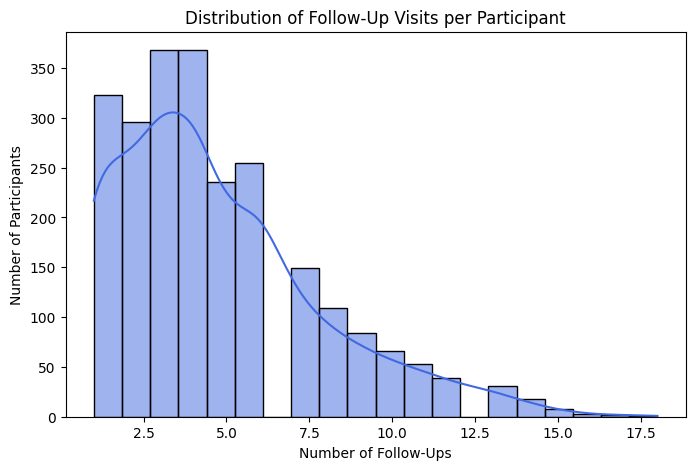

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(transition_df["Total Follow-Ups"],
             bins=20, kde=True, color="royalblue")
plt.xlabel("Number of Follow-Ups")
plt.ylabel("Number of Participants")
plt.title("Distribution of Follow-Up Visits per Participant")
plt

In [29]:
df['VISCODE'].unique()

array(['bl', 'm06', 'm12', 'm24', 'm18', 'm36', 'm48', 'm60', 'm72',
       'm108', 'm96', 'm84', 'm120', 'm132', 'm144', 'm156', 'm42',
       'm168', 'm180', 'm174', 'm162', 'm138', 'm150', 'm102', 'm90',
       'm114', 'm78', 'm126', 'm66', 'm54', 'm30', 'm186', 'm192', 'm198',
       'm204'], dtype=object)

In [30]:
valid_visits = ["m06", "m12", "m24"]

df["VISCODE"] = df["VISCODE"].astype(str)

df_filtered = df[(df["VISCODE"] == "bl") | (df["VISCODE"].isin(valid_visits))]

valid_participant_counts = df_filtered.groupby("RID")["VISCODE"].count()

valid_participants = valid_participant_counts[valid_participant_counts > 1].index

df_final = df_filtered[df_filtered["RID"].isin(valid_participants)]

df_final = df_final.sort_values(by=["RID", "VISCODE"])

conversion_data = []

for rid in df_final["RID"].unique():
    subset = df_final[df_final["RID"] == rid].sort_values("VISCODE")

    baseline_dx = subset[subset["VISCODE"] == "bl"]["DX_bl"].values[0]

    follow_up_dx = subset[subset["VISCODE"].isin(
        valid_visits)]["DX"].dropna().values

    if len(follow_up_dx) > 0 and baseline_dx != follow_up_dx[-1]:
        converted = "Yes"
        final_dx = follow_up_dx[-1]
    else:
        converted = "No"
        final_dx = baseline_dx 

    conversion_data.append({
        "RID": rid,
        "Baseline_DX": baseline_dx,
        "Converted?": converted,
        "Final_DX": final_dx
    })

conversion_df = pd.DataFrame(conversion_data)

conversion_summary = conversion_df.groupby(
    ["Baseline_DX", "Converted?", "Final_DX"]).agg({"RID": "count"}).reset_index()
conversion_summary.rename(
    columns={"RID": "Number of Participants"}, inplace=True)

In [31]:
conversion_summary

,Baseline_DX,Converted?,Final_DX,Number of Participants
0,AD,Yes,Dementia,349
1,AD,Yes,MCI,5
2,CN,No,CN,441
3,CN,Yes,Dementia,2
4,CN,Yes,MCI,24
5,EMCI,Yes,CN,22
6,EMCI,Yes,Dementia,22
7,EMCI,Yes,MCI,313
8,LMCI,Yes,CN,23
9,LMCI,Yes,Dementia,207


In [32]:
summary = pd.read_csv("DXSUM_13Feb2025.csv")

In [33]:
summary['RID'].nunique()

3387

In [2]:
ucsl = pd.read_csv("Files/UCSFFSL_02_01_16_13Feb2025.csv")
ucsx = pd.read_csv("Files/UCSFFSX7_13Feb2025.csv")

In [3]:
pd.concat

<function pandas.core.reshape.concat.concat(objs: 'Iterable[NDFrame] | Mapping[HashableT, NDFrame]', *, axis: 'Axis' = 0, join: 'str' = 'outer', ignore_index: 'bool' = False, keys=None, levels=None, names=None, verify_integrity: 'bool' = False, sort: 'bool' = False, copy: 'bool' = True) -> 'DataFrame | Series'>

In [4]:
ucsl['RID'].nunique()

761

In [5]:
ucsl.groupby("STATUS")['RID'].nunique()

STATUS
complete    755
partial      24
Name: RID, dtype: int64

In [6]:
ucsx['RID'].nunique()

1987

In [7]:
A = ucsl['RID'].unique()
B = ucsx['RID'].unique()
A_set = set(A)
B_set = set(B)
intersection = A_set.intersection(B_set)

In [8]:
len(intersection)

125

In [9]:
len(set(ucsx['RID']))

1987

In [10]:
ucsx['RID'].value_counts()

2245    14
4723    12
4722    12
4489    12
2155    11
        ..
6043     1
2314     1
6736     1
6892     1
6093     1
Name: RID, Length: 1987, dtype: int64

In [11]:
ucsx[ucsx['RID']==2245]

,PHASE,PTID,RID,VISCODE,VISCODE2,IMAGEUID,EXAMDATE,RUNDATE,STATUS,FSVER,...,ST147SV,ST148SV,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp
241,ADNI3,027_S_2245,2245,y3,m108,1273255,2020-01-07,2024-11-19,partial,7.2.0,...,203811.839843,205068.718464,408880.558307,188046.0,191318.0,379364.0,51801.0,557076.558307,867643.0,2024-12-02 08:27:54.0
708,ADNI3,027_S_2245,2245,y4,m120,1396127,2021-01-05,2022-09-28,partial,7.2.0,...,200301.890590,203798.052032,404099.942622,187968.5,192352.5,380321.0,51708.0,553841.942622,864260.0,2024-12-02 08:27:54.0
730,ADNI3,027_S_2245,2245,y1,m84,950878,2018-01-03,2022-09-13,partial,7.2.0,...,208848.957487,206737.678967,415586.636453,194599.5,192633.5,387233.0,53172.0,567177.636453,880521.0,2024-12-02 08:27:54.0
1137,ADNI3,027_S_2245,2245,init,m72,814950,2017-02-01,2022-09-13,partial,7.2.0,...,202666.463800,200161.218196,402827.681996,202318.5,204684.5,407003.0,52831.0,554822.681996,887294.0,2024-12-02 08:27:54.0
1679,ADNIGO,027_S_2245,2245,m12,m12,281891,2012-01-12,2022-09-11,partial,7.2.0,...,204853.144956,204265.968427,409119.113383,217338.0,216089.0,433427.0,54051.0,558932.113383,917537.0,2024-12-02 08:27:54.0
1795,ADNI4,027_S_2245,2245,4_init,m162,10955636,2024-07-02,2024-10-17,complete,7.4.1,...,195770.247859,198739.050239,394509.298097,200148.5,200381.5,400530.0,50097.0,540480.298097,876031.0,2024-12-02 08:27:54.0
2244,ADNIGO,027_S_2245,2245,scmri,scmri,222935,2010-12-14,2022-09-11,partial,7.2.0,...,200616.461417,201602.063015,402218.524432,208667.0,208215.0,416882.0,51475.0,549134.524432,890902.0,2024-12-02 08:27:54.0
2384,ADNIGO,027_S_2245,2245,m06,m06,241368,2011-06-06,2022-09-11,partial,7.2.0,...,205156.090332,203252.988850,408409.079181,209512.0,208523.0,418035.0,53956.0,558175.079181,900638.0,2024-12-02 08:27:54.0
2624,ADNIGO,027_S_2245,2245,m03,m03,225374,2011-03-19,2022-09-11,partial,7.2.0,...,206394.571662,204948.659601,411343.231263,209267.0,210061.0,419328.0,53732.0,562057.231263,906009.0,2024-12-02 08:27:54.0
2634,ADNI2,027_S_2245,2245,v11,m36,427971,2014-01-13,2022-09-11,partial,7.2.0,...,200980.248796,200620.682594,401600.931390,216080.5,215906.5,431987.0,52269.0,550302.931390,907227.0,2024-12-02 08:27:54.0


In [12]:
ucsl['STATUS'].value_counts()

complete    3537
partial       33
Name: STATUS, dtype: int64

In [13]:
ucsx['STATUS'].value_counts()

partial     6123
complete     208
Name: STATUS, dtype: int64

In [14]:
ucsx[ucsx['STATUS']=='complete']

,PHASE,PTID,RID,VISCODE,VISCODE2,IMAGEUID,EXAMDATE,RUNDATE,STATUS,FSVER,...,ST147SV,ST148SV,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp
12,ADNI4,941_S_6471,6471,4_m12,m72,10932490,2024-08-27,2024-10-16,complete,7.4.1,...,246390.072695,246485.281979,492875.354675,239296.5,239755.5,479052.0,61836.0,671169.354675,1052429.0,2024-12-02 08:27:54.0
17,ADNI4,007_S_10130,10130,4_sc,sc,10889389,2024-07-23,2024-10-17,complete,7.4.1,...,251393.373724,249248.010123,500641.383847,215999.5,214722.5,430722.0,56063.0,670188.383847,1029766.0,2024-12-02 08:27:54.0
22,ADNI4,052_S_10202,10202,4_sc,sc,10932473,2024-08-27,2024-10-17,complete,7.4.1,...,227780.196222,227975.058319,455755.254541,188473.0,184403.0,372876.0,47259.0,602171.254541,892842.0,2024-12-02 08:27:54.0
98,ADNI4,100_S_10028,10028,4_sc,sc,10651644,2024-01-19,2024-07-24,complete,7.4.1,...,213508.105006,217772.606187,431280.711193,234084.5,228635.5,462720.0,52756.0,587592.711193,966262.0,2024-12-02 08:27:54.0
143,ADNI4,073_S_10120,10120,4_sc,sc,10974321,2024-05-28,2024-11-21,complete,7.4.1,...,217345.090829,212897.080900,430242.171730,229551.5,222070.5,451622.0,52922.0,597737.171730,987207.0,2024-12-02 08:27:54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6218,ADNI4,033_S_10229,10229,4_sc,sc,10957118,2024-09-16,2024-11-18,complete,7.4.1,...,203862.454375,204207.738446,408070.192821,175414.0,173285.0,348699.0,50473.0,566210.192821,841479.0,2024-12-02 08:27:54.0
6237,ADNI4,014_S_10180,10180,4_sc,sc,10911593,2024-08-07,2024-11-07,complete,7.4.1,...,161705.627632,162768.111949,324473.739581,133168.0,134793.0,267961.0,48637.0,468063.739581,654177.0,2024-12-02 08:27:54.0
6291,ADNI4,301_S_10194,10194,4_sc,sc,10913996,2024-08-09,2024-11-13,complete,7.4.1,...,152134.615089,166880.250030,319014.865119,165815.0,177350.0,343165.0,46636.0,446474.865119,738300.0,2024-12-02 08:27:54.0
6294,ADNI4,027_S_6788,6788,4_init,m60,10968666,2024-10-03,2024-10-17,complete,7.4.1,...,193153.649447,201779.629722,394933.279170,203589.0,202465.0,406054.0,49373.0,561677.279170,895851.0,2024-12-02 08:27:54.0


In [15]:
ucsl['VISCODE2'].value_counts()

sc     756
m06    728
m12    678
m24    539
m36    341
m18    303
m48    168
m60     29
bl      18
f       10
Name: VISCODE2, dtype: int64

In [16]:
ucsl['FLDSTRENG'].value_counts()

1.5    3570
Name: FLDSTRENG, dtype: int64

In [17]:
ucsl['PHASE'].value_counts()

KeyError: 'PHASE'

In [18]:
ucsl['RID'].value_counts()

361     8
389     8
1066    8
835     8
925     8
       ..
1253    2
872     2
1250    1
221     1
473     1
Name: RID, Length: 761, dtype: int64

In [20]:
regions = pd.read_csv("Files/mri_regional_dict_proper_all.csv")

In [21]:
code_to_region = dict(zip(regions["ADNI Code"], regions["Region"]))

In [22]:
relevant_columns = ["RID", "VISCODE2"] + list(code_to_region.keys())

In [23]:
ucsl_df = ucsl.loc[:, ucsl.columns.isin(relevant_columns)]

In [24]:
ucsx_df = ucsx.loc[:, ucsx.columns.isin(relevant_columns)]

In [25]:
# ucsl_df.rename(columns=code_to_region, inplace=True)
# ucsx_df.rename(columns=code_to_region, inplace=True)

In [26]:
df.rename(columns={"VISCODE": "VISCODE2"}, inplace=True)

NameError: name 'df' is not defined

In [27]:
pd.merge(df, ucsl_df, on=["RID", "VISCODE2"])['VISCODE2'].value_counts()

NameError: name 'df' is not defined

C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\4022235970.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=viscode2_counts.index, y=viscode2_counts.values, palette="viridis")


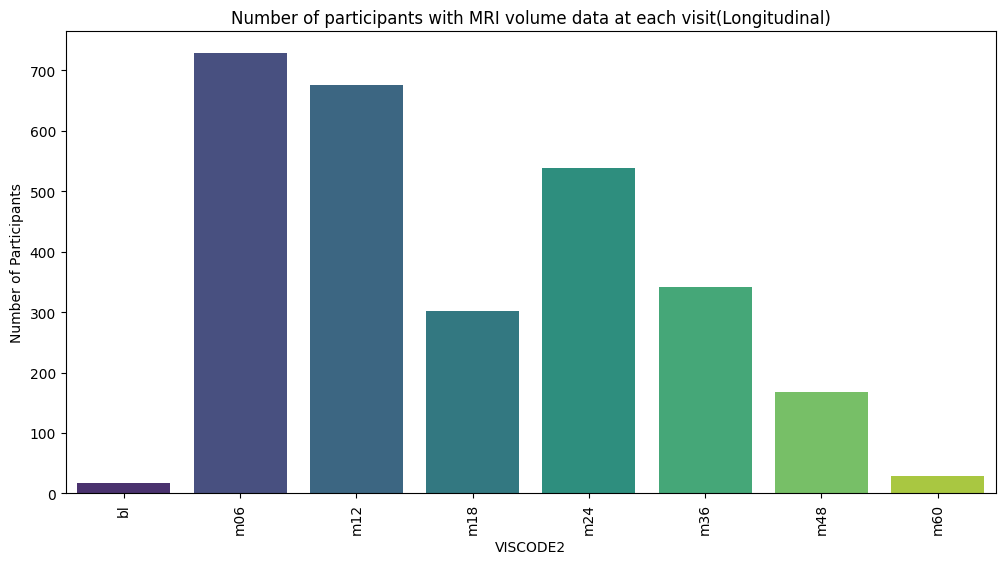

In [46]:
viscode2_counts = pd.merge(df, ucsl_df, on=["RID", "VISCODE2"])['VISCODE2'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=viscode2_counts.index, y=viscode2_counts.values, palette="viridis")
plt.xlabel('VISCODE2')
plt.ylabel('Number of Participants')
plt.title('Number of participants with MRI volume data at each visit(Longitudinal)')
plt.xticks(rotation=90)
plt.show()

C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\2608705277.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=viscode2_counts.index,


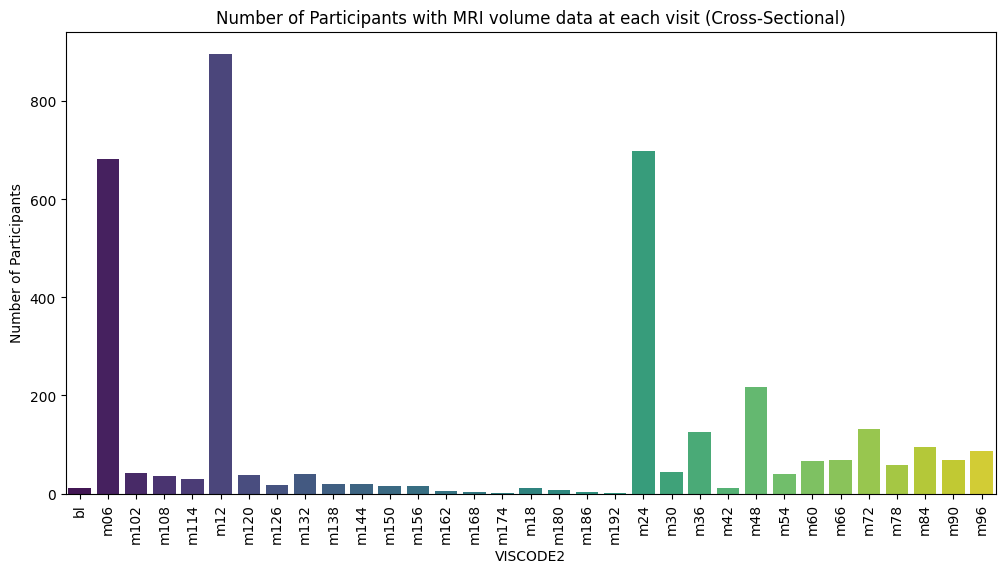

In [47]:
viscode2_counts = pd.merge(df, ucsx_df, on=["RID", "VISCODE2"])[
    'VISCODE2'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=viscode2_counts.index,
            y=viscode2_counts.values, palette="viridis")
plt.xlabel('VISCODE2')
plt.ylabel('Number of Participants')
plt.title('Number of Participants with MRI volume data at each visit (Cross-Sectional)')
plt.xticks(rotation=90)
plt.show()

In [48]:
brain_regions = ['Ventricles', 'Hippocampus', 'WholeBrain',
                 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
region_columns = [region + "_bl" for region in brain_regions] + brain_regions
selected_cols = ["RID", "VISCODE", "DX_bl"] + region_columns
adnimerge_col = adnimerge[selected_cols]

In [49]:
adnimerge_col = adnimerge_col.dropna(subset=["DX_bl"] + region_columns)

In [50]:
adnimerge_col

,RID,VISCODE,DX_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,2,bl,CN,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0
1,3,bl,AD,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0
2,3,m06,AD,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0
3,3,m12,AD,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0
4,3,m24,AD,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16218,6473,m48,CN,27225.8,6344.9,944955.0,3915.0,17965.0,24703.0,1290220.0,32282.1,6465.5,927607.0,4142.0,17707.0,23594.0,1276700.0
16235,7114,bl,SMC,15983.4,7717.3,1015040.0,3701.0,17860.0,16735.0,1326860.0,15983.4,7717.3,1015040.0,3701.0,17860.0,16735.0,1326860.0
16238,2155,m144,EMCI,12574.0,7712.0,1083240.0,5057.0,20785.0,21346.0,1429900.0,38172.6,5097.0,952461.0,3500.0,16478.0,18961.0,1341300.0
16242,6209,m30,SMC,22778.0,7649.6,1100120.0,4076.0,21177.0,22896.0,1534440.0,25142.9,7484.5,1071710.0,4873.0,20898.0,22361.0,1536490.0


In [51]:
adnimerge_col["VISCODE"] = adnimerge_col["VISCODE"].str.extract("(\d+)").fillna(0).astype(int)

In [52]:
for region in brain_regions:
    adnimerge_col[region + "_change"] = adnimerge_col[region] - adnimerge_col[region + "_bl"]

In [53]:
adnimerge_col = adnimerge_col.melt(id_vars=["RID", "VISCODE", "DX_bl"], value_vars=[region + "_change" for region in brain_regions],
             var_name="Brain Region", value_name="Volume Change")

In [54]:
adnimerge_col["Brain Region"] = adnimerge_col["Brain Region"].str.replace("_change", "")

In [55]:
adnimerge_col

,RID,VISCODE,DX_bl,Brain Region,Volume Change
0,2,0,CN,Ventricles,0.0
1,3,0,AD,Ventricles,0.0
2,3,6,AD,Ventricles,3981.0
3,3,12,AD,Ventricles,5500.0
4,3,24,AD,Ventricles,12821.0
...,...,...,...,...,...
50402,6473,48,CN,ICV,-13520.0
50403,7114,0,SMC,ICV,0.0
50404,2155,144,EMCI,ICV,-88600.0
50405,6209,30,SMC,ICV,2050.0


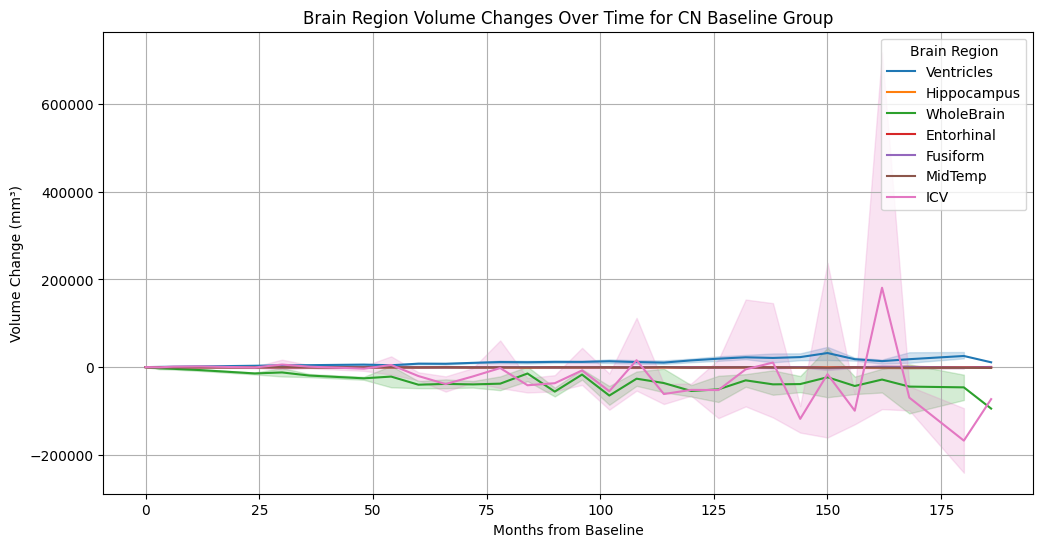

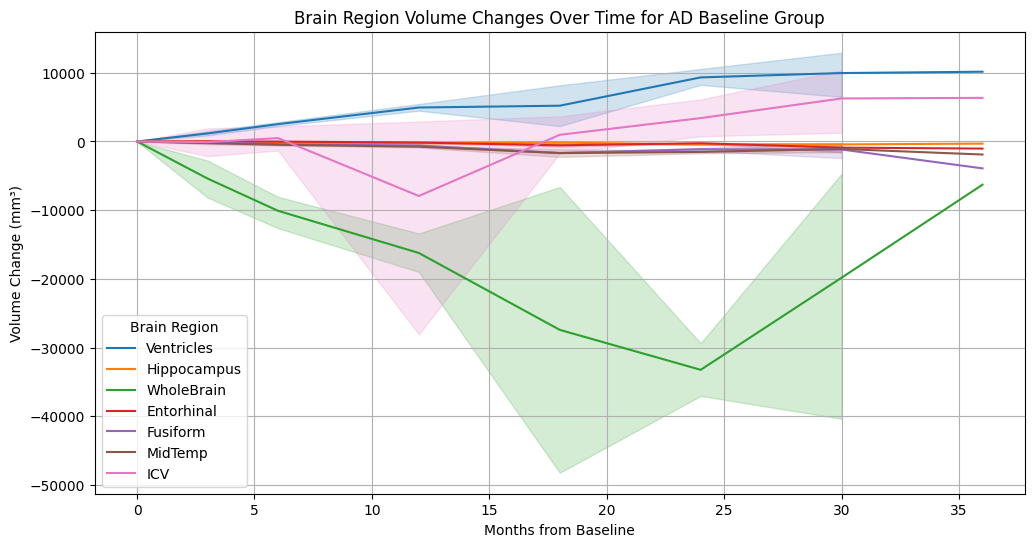

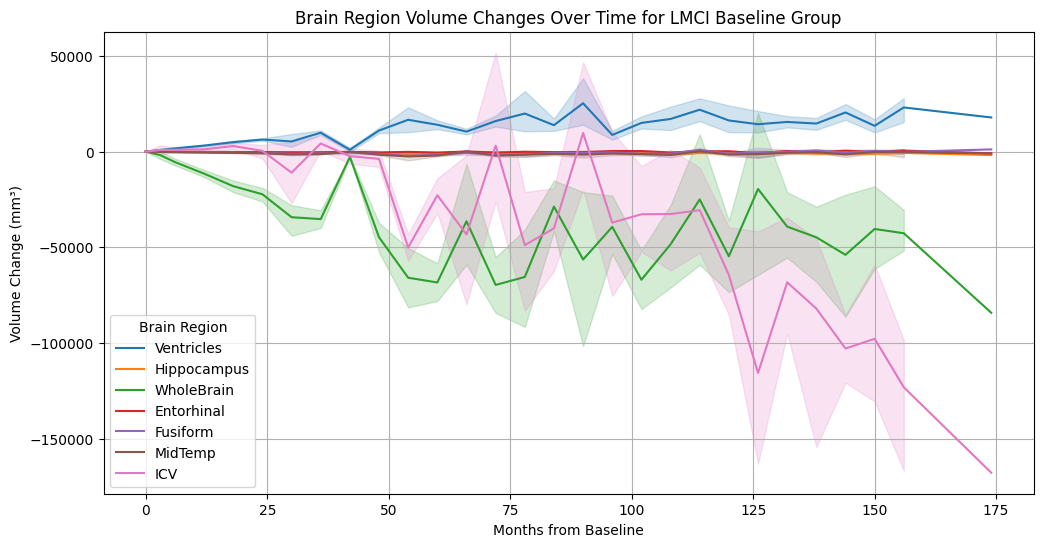

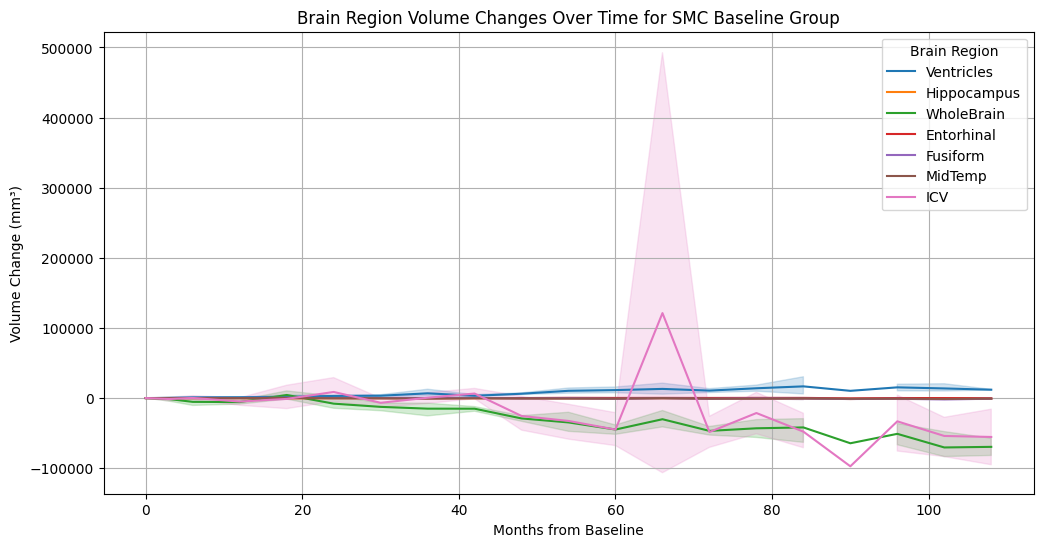

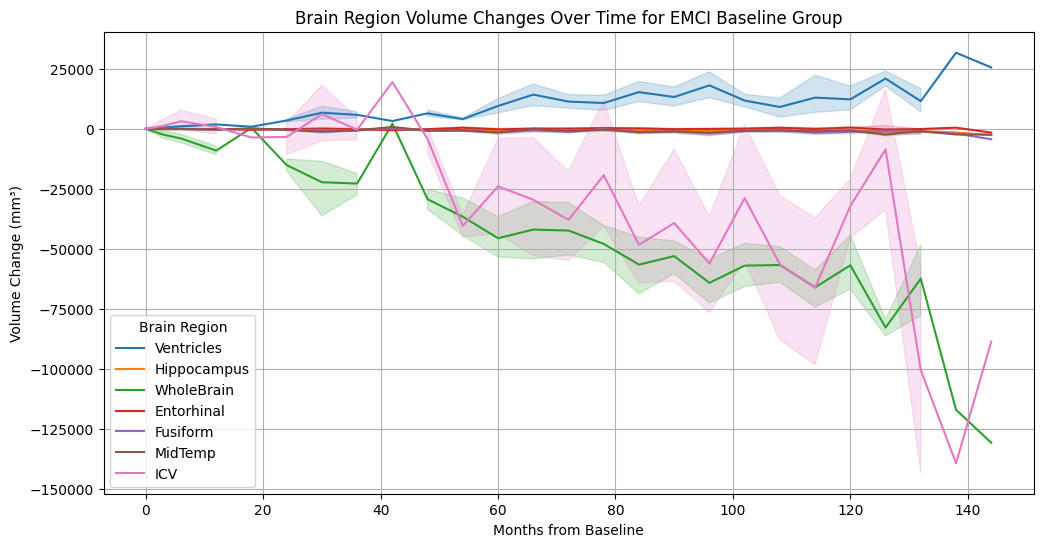

In [56]:
dx_groups = adnimerge_col["DX_bl"].unique()

for dx in dx_groups:
    plt.figure(figsize=(12, 6))
    subset = adnimerge_col[adnimerge_col["DX_bl"] == dx]
    sns.lineplot(data=subset, x="VISCODE", y="Volume Change",
                 hue="Brain Region", markers=True)

    plt.xlabel("Months from Baseline")
    plt.ylabel("Volume Change (mm³)")
    plt.title(f"Brain Region Volume Changes Over Time for {dx} Baseline Group")
    plt.legend(title="Brain Region")
    plt.grid(True)
    plt.show()

<Axes: xlabel='Brain Region', ylabel='Volume Change'>

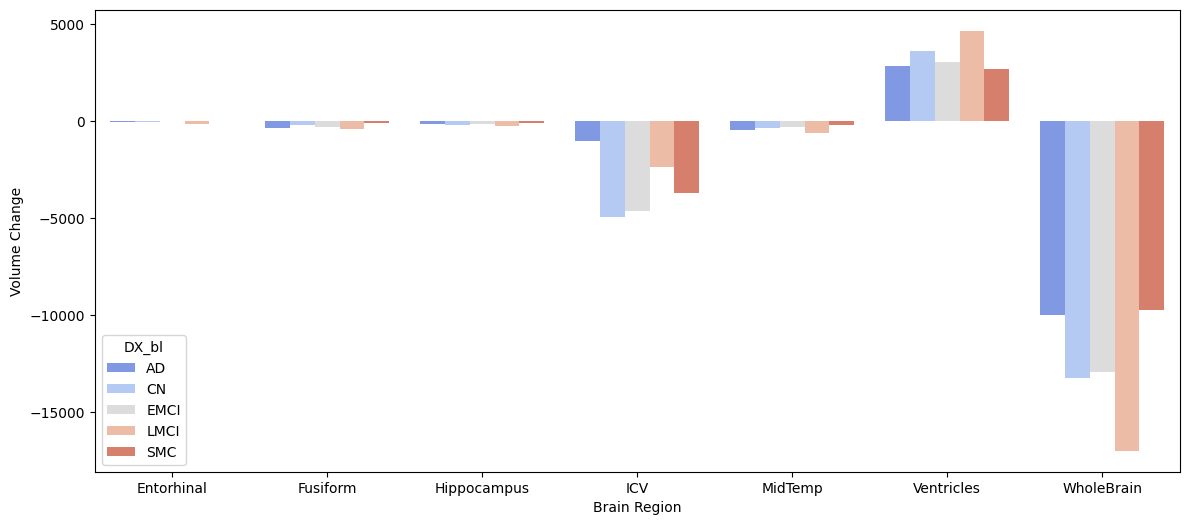

In [57]:
# adnimerge_col.groupby(["DX_bl", "Brain Region"])[
#     "Volume Change"].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(data=adnimerge_col.groupby(["DX_bl", "Brain Region"])[
    "Volume Change"].mean().reset_index(), x="Brain Region",
            y="Volume Change", hue="DX_bl", palette="coolwarm")

In [58]:
sleep = pd.read_csv("NPIQ_07Feb2025.csv")
sleep

,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,SOURCE,NPIA,NPIASEV,NPIB,...,NPISCORE,SPID,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0002,2,bl,bl,2005-09-08,1.0,0.0,-4.0,0.0,...,0.0,NaN,4,107,2005-09-09,NaN,NaN,NaN,NaN,2005-09-09 00:00:00.0
1,ADNI1,011_S_0003,3,bl,bl,2005-09-12,1.0,0.0,-4.0,0.0,...,1.0,NaN,6,107,2005-09-13,NaN,NaN,NaN,NaN,2005-09-13 00:00:00.0
2,ADNI1,011_S_0005,5,bl,bl,2005-09-07,1.0,0.0,-4.0,0.0,...,0.0,NaN,8,107,2005-09-14,NaN,NaN,NaN,NaN,2005-09-14 00:00:00.0
3,ADNI1,011_S_0008,8,bl,bl,2005-09-19,2.0,0.0,-4.0,0.0,...,0.0,NaN,10,107,2005-09-26,NaN,NaN,NaN,NaN,2005-09-26 00:00:00.0
4,ADNI1,022_S_0007,7,bl,bl,2005-10-06,1.0,0.0,-4.0,0.0,...,10.0,NaN,12,10,2005-10-13,NaN,NaN,NaN,NaN,2005-10-13 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,ADNI4,016_S_6941,6941,4_m12,m42,2025-01-16,2.0,0.0,NaN,0.0,...,0.0,1.0,61490,16,2025-01-20,2025-01-20,v1,e,0.0,2025-01-22 00:45:36.0
7159,ADNI4,007_S_6255,6255,4_init,m84,2025-01-14,2.0,0.0,NaN,0.0,...,0.0,1.0,61555,7,2025-01-20,2025-01-20,v1,e,0.0,2025-01-22 00:45:36.0
7160,ADNI4,011_S_6303,6303,4_m12,m78,2025-01-14,2.0,0.0,NaN,0.0,...,5.0,1.0,62283,11,2025-01-23,2025-01-23,v1,e,0.0,2025-01-25 00:42:25.0
7161,ADNI4,100_S_4556,4556,4_m12,m150,2025-01-23,2.0,0.0,NaN,0.0,...,0.0,1.0,62424,100,2025-01-23,2025-01-23,v1,e,0.0,2025-01-25 00:42:25.0


In [59]:
npiq_use = sleep[['PHASE', 'RID','VISCODE2','NPIK','NPIKSEV']]

In [60]:
symptoms = pd.read_csv("ADSXLIST_13Feb2025.csv")
symptoms

,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,AXNAUSEA,AXVOMIT,AXDIARRH,AXCONSTP,...,AXCRYING,AXELMOOD,AXWANDER,AXFALL,AXOTHER,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,ADNI1,011_S_0002,2,m06,m06,2006-03-06,1,1,1,1,...,1,1,1,1,1.0,2,107,2006-03-07,NaN,2006-03-07 00:00:00.0
1,ADNI1,011_S_0005,5,m06,m06,2006-03-09,1,1,1,1,...,1,1,1,1,2.0,4,107,2006-03-09,NaN,2006-03-09 00:00:00.0
2,ADNI1,011_S_0003,3,m06,m06,2006-03-13,1,1,1,1,...,1,1,1,1,1.0,6,107,2006-03-13,NaN,2006-03-13 00:00:00.0
3,ADNI1,011_S_0008,8,m06,m06,2006-03-20,1,1,1,2,...,1,1,1,2,1.0,8,107,2006-03-21,NaN,2006-03-21 00:00:00.0
4,ADNI1,022_S_0007,7,m06,m06,2006-04-13,1,1,1,1,...,2,1,1,1,1.0,10,10,2006-04-13,NaN,2006-04-13 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,ADNIGO,027_S_2336,2336,m18,m18,2012-10-05,1,1,1,1,...,1,1,1,1,2.0,1362,19,2012-11-05,NaN,2012-11-16 09:38:45.0
4880,ADNIGO,052_S_2249,2249,m18,m18,2012-06-18,1,1,1,1,...,1,1,1,1,1.0,1364,29,2013-01-08,NaN,2013-01-08 19:00:13.0
4881,ADNIGO,051_S_1040,1040,m66,m66,2012-12-06,1,1,1,1,...,1,1,1,1,1.0,1366,28,2014-01-20,NaN,2014-01-21 19:00:15.0
4882,ADNIGO,082_S_0832,832,m48,m48,2010-12-16,1,1,1,1,...,1,1,2,1,1.0,1368,36,2014-01-28,NaN,2014-01-28 19:00:15.0


In [61]:
insom_absent = symptoms[symptoms['AXINSOMN']==1]
insom_present = symptoms[symptoms['AXINSOMN']==2]

In [62]:
no_insom = insom_absent['RID'].unique()
yes_insom = insom_present['RID'].unique()

In [63]:
correlation_matrix = symptoms.corr()
axinsomn_correlation = correlation_matrix["AXINSOMN"].sort_values(ascending=False).head(10)
axinsomn_correlation

C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\2768786379.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = symptoms.corr()


AXINSOMN    1.000000
AXABDOMN    0.233741
AXNAUSEA    0.228399
AXDIARRH    0.223332
AXMUSCLE    0.222036
AXCRYING    0.218931
AXCHEST     0.218119
AXENERGY    0.217057
AXVISION    0.215395
AXWANDER    0.214599
Name: AXINSOMN, dtype: float64

In [64]:
npiq_use

,PHASE,RID,VISCODE2,NPIK,NPIKSEV
0,ADNI1,2,bl,0.0,-4.0
1,ADNI1,3,bl,0.0,-4.0
2,ADNI1,5,bl,0.0,-4.0
3,ADNI1,8,bl,0.0,-4.0
4,ADNI1,7,bl,1.0,1.0
...,...,...,...,...,...
7158,ADNI4,6941,m42,0.0,NaN
7159,ADNI4,6255,m84,0.0,NaN
7160,ADNI4,6303,m78,1.0,2.0
7161,ADNI4,4556,m150,0.0,NaN


In [65]:
df[df['RID'].isin(no_insom)].groupby('DX_bl')['RID'].nunique()

DX_bl
AD      171
CN      215
EMCI    112
LMCI    374
Name: RID, dtype: int64

In [66]:
df[df['RID'].isin(yes_insom)].groupby('DX_bl')['RID'].nunique()

DX_bl
AD      26
CN      63
EMCI    37
LMCI    96
Name: RID, dtype: int64

In [67]:
df

,RID,VISCODE2,AGE,DX,DX_bl,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,2,bl,74.3,CN,CN,Male,16,Not Hisp/Latino,White,Married,0.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0
1,3,bl,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0
2,3,m06,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0
3,3,m12,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0
4,3,m24,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16403,6180,m66,86.8,MCI,LMCI,Male,16,Not Hisp/Latino,White,Married,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
16405,6446,m60,61.5,MCI,EMCI,Male,12,Not Hisp/Latino,White,Married,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
16409,6731,m48,66.8,Dementia,EMCI,Female,20,Not Hisp/Latino,White,Married,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
16410,6480,m60,79.9,MCI,LMCI,Female,16,Not Hisp/Latino,White,Widowed,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [68]:
symptoms_insom_all = symptoms[['RID','AXINSOMN','VISCODE2']].rename(columns={'VISCODE2':'VISCODE'})

In [71]:
df.rename(columns={'VISCODE2':'VISCODE'}, inplace=True)

In [72]:
df_merge_ins = pd.merge(df, symptoms_insom_all, on=['RID','VISCODE'])

In [73]:
df_merge_ins[df_merge_ins['RID']==2]

,RID,VISCODE,AGE,DX,DX_bl,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,AXINSOMN
2300,2,m06,74.3,CN,CN,Male,16,Not Hisp/Latino,White,Married,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1
2301,2,m36,74.3,CN,CN,Male,16,Not Hisp/Latino,White,Married,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1
2302,2,m60,74.3,CN,CN,Male,16,Not Hisp/Latino,White,Married,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1


In [74]:
def get_transitions(df):
    transition_data = []

    for rid in df["RID"].unique():
        subset = df[df["RID"] == rid].sort_values("VISCODE")

        # Get baseline diagnosis
        baseline_dx = subset["DX_bl"].iloc[0]

        # Get all follow-up diagnoses, dropping NaNs
        follow_up_dx = subset["DX"].dropna().unique()

        # Handle missing follow-up diagnosis case
        if len(follow_up_dx) == 0:
            transition_data.append({
                "RID": rid,
                "Baseline_DX": baseline_dx,
                "Converted": "No",
                "Final_DX": "No Follow-Up"
            })
        elif baseline_dx != follow_up_dx[-1]:
            transition_data.append({
                "RID": rid,
                "Baseline_DX": baseline_dx,
                "Converted": "Yes",
                "Final_DX": follow_up_dx[-1]
            })
        else:
            transition_data.append({
                "RID": rid,
                "Baseline_DX": baseline_dx,
                "Converted": "No",
                "Final_DX": baseline_dx
            })

    return pd.DataFrame(transition_data)


# Get transitions for No Insomnia and Yes Insomnia groups
transition_no_insom = get_transitions(
    df_merge_ins[df_merge_ins["RID"].isin(no_insom)])
transition_yes_insom = get_transitions(
    df_merge_ins[df_merge_ins["RID"].isin(yes_insom)])

# Count transitions for both groups
transition_counts_no_insom = transition_no_insom.groupby(
    ["Baseline_DX", "Converted"]).size().reset_index(name="Count")
transition_counts_yes_insom = transition_yes_insom.groupby(
    ["Baseline_DX", "Converted"]).size().reset_index(name="Count")

# Add insomnia label for merging
transition_counts_no_insom["Insomnia"] = "No Insomnia"
transition_counts_yes_insom["Insomnia"] = "Yes Insomnia"

# Merge both dataframes
transition_counts = pd.concat(
    [transition_counts_no_insom, transition_counts_yes_insom])

In [75]:
transition_counts

,Baseline_DX,Converted,Count,Insomnia
0,AD,Yes,171,No Insomnia
1,CN,No,186,No Insomnia
2,CN,Yes,29,No Insomnia
3,EMCI,Yes,112,No Insomnia
4,LMCI,Yes,374,No Insomnia
0,AD,Yes,26,Yes Insomnia
1,CN,No,53,Yes Insomnia
2,CN,Yes,10,Yes Insomnia
3,EMCI,Yes,37,Yes Insomnia
4,LMCI,Yes,96,Yes Insomnia


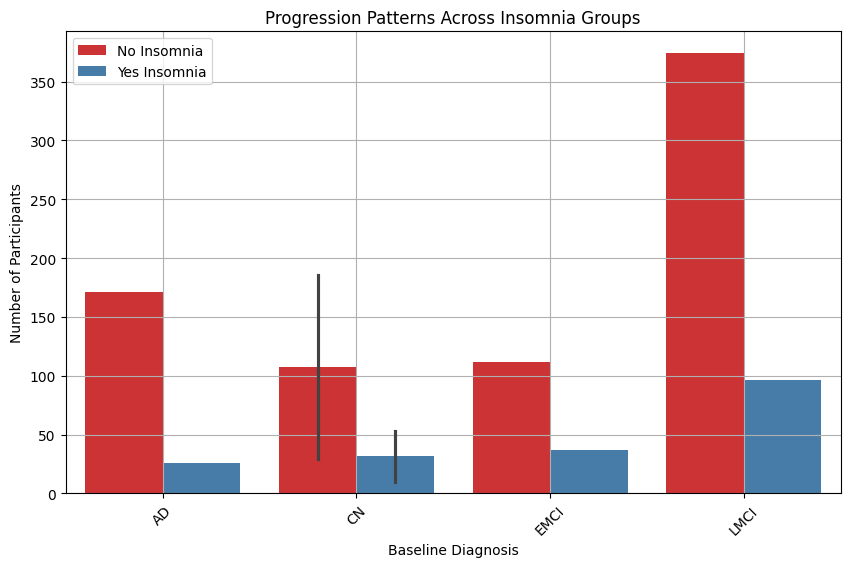

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(data=transition_counts, x="Baseline_DX", y="Count",
            hue="Insomnia", palette="Set1")

plt.xlabel("Baseline Diagnosis")
plt.ylabel("Number of Participants")
plt.title("Progression Patterns Across Insomnia Groups")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [78]:
df_unique = df_merge_ins.sort_values(
    "VISCODE").drop_duplicates(subset=["RID"], keep="first")

df_demo = df_unique[["RID", "DX_bl", "AGE", "PTGENDER",
                     "PTEDUCAT", "PTETHCAT", "PTRACCAT", "PTMARRY"]].dropna()

summary_table = df_demo.groupby("DX_bl").agg({
    "AGE": ["mean", "std"],
    "PTGENDER": lambda x: x.value_counts().to_dict(),
    "PTEDUCAT": ["mean", "std"],
    "PTETHCAT": lambda x: x.value_counts().to_dict(),
    "PTRACCAT": lambda x: x.value_counts().to_dict(),
    "PTMARRY": lambda x: x.value_counts().to_dict(),
}).reset_index()

In [79]:
df_demo_sleep = df_unique[["RID", "DX_bl", "AGE", "PTGENDER",
                           "PTEDUCAT", "PTETHCAT", "PTRACCAT", "PTMARRY", "AXINSOMN"]].dropna()

df_demo_sleep["Sleep_Disturbance"] = df_demo_sleep["AXINSOMN"].map(
    {1: "No Insomnia", 2: "Yes Insomnia"})

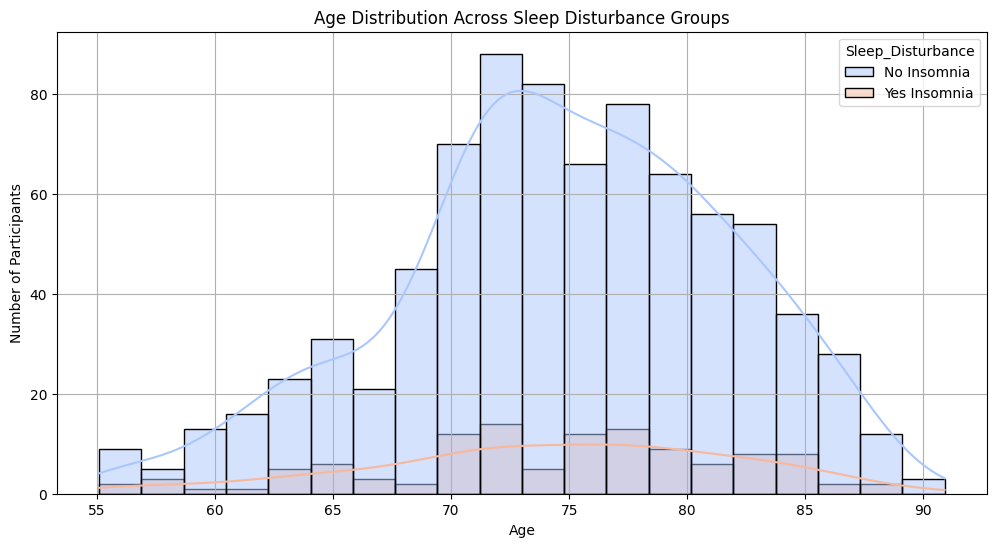

In [80]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_demo_sleep, x="AGE", hue="Sleep_Disturbance",
             kde=True, bins=20, palette="coolwarm")

plt.xlabel("Age")
plt.ylabel("Number of Participants")
plt.title("Age Distribution Across Sleep Disturbance Groups")
plt.grid(True)
plt.show()

C:\Users\anisr\AppData\Local\Temp\ipykernel_8732\1551111957.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_demo_sleep, x="Sleep_Disturbance",


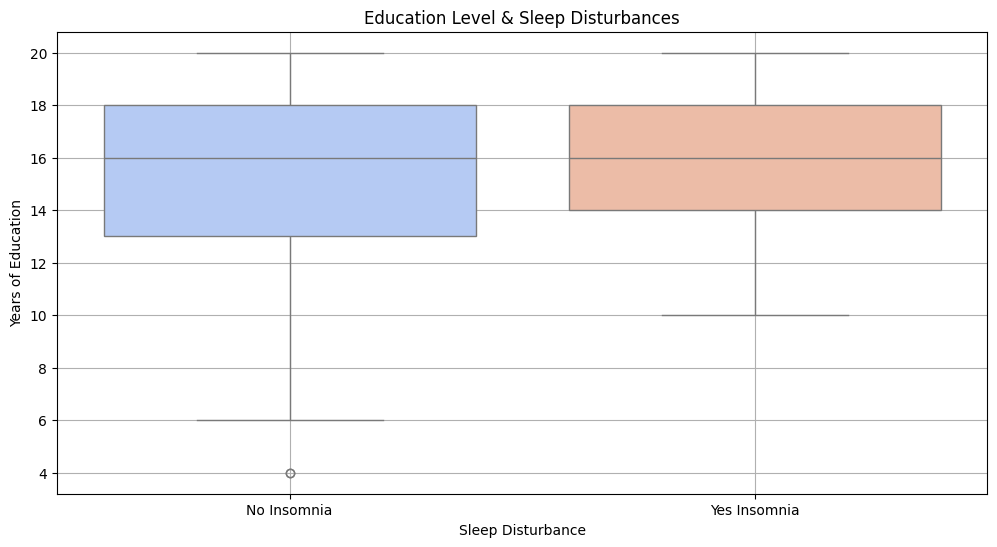

In [81]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_demo_sleep, x="Sleep_Disturbance",
            y="PTEDUCAT", palette="coolwarm")

plt.xlabel("Sleep Disturbance")
plt.ylabel("Years of Education")
plt.title("Education Level & Sleep Disturbances")
plt.grid(True)
plt.show()

In [83]:
ucsl_df

,RID,VISCODE2,RightNonWMHypoIntensities,RightPallidum,RightParacentral,RightParacentral,RightParacentral,RightParacentral,RightParahippocampal,RightParahippocampal,...,RightLingual,RightMedialOrbitofrontal,RightMedialOrbitofrontal,RightMedialOrbitofrontal,RightMedialOrbitofrontal,RightMiddleTemporal,RightMiddleTemporal,RightMiddleTemporal,RightMiddleTemporal,FourthVentricle
0,3,m06,NaN,1498,2927,1777,1.665,0.447,1904,763,...,0.640,4253,2131,2.034,0.720,10022,3475,2.525,0.693,2808
1,3,m12,NaN,1519,2935,1802,1.683,0.439,1826,732,...,0.630,4158,2171,1.991,0.678,9758,3493,2.448,0.670,2939
2,3,m24,NaN,1541,3038,1733,1.783,0.551,1669,720,...,0.617,3901,2091,1.893,0.648,9237,3243,2.431,0.671,2987
3,3,sc,NaN,1661,3261,1683,1.912,0.638,1936,722,...,0.608,4046,1947,2.021,0.745,10097,3292,2.579,0.659,2863
4,4,m06,NaN,1285,3021,1578,1.922,0.521,2110,725,...,0.573,3838,1638,2.138,0.656,10872,3526,2.645,0.639,1396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,1427,m24,NaN,1123,3234,1365,2.212,0.581,2154,553,...,0.784,4056,1495,2.633,0.646,12400,3493,2.978,0.654,2120
3566,1427,m48,NaN,1081,3232,1374,2.160,0.595,2017,540,...,0.807,3713,1453,2.369,0.726,12131,3516,2.855,0.761,2747
3567,1427,sc,NaN,1230,3220,1389,2.212,0.603,2146,548,...,0.835,4004,1480,2.623,0.700,12499,3698,2.937,0.702,2288
3568,1430,m06,NaN,1235,3067,1391,2.072,0.712,1795,520,...,0.640,3250,1273,2.544,0.789,7414,2259,2.775,0.610,1294


In [85]:
df_merge_ins

,RID,VISCODE,AGE,DX,DX_bl,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,AXINSOMN
0,3,m06,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,2
1,3,m12,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,2
2,3,m24,81.3,Dementia,AD,Male,18,Not Hisp/Latino,White,Married,1.0,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0,2
3,4,m06,67.5,MCI,LMCI,Male,10,Hisp/Latino,White,Married,0.0,39726.0,6439.0,1116280.0,3711.0,17899.0,20139.0,1661130.0,1
4,4,m12,67.5,MCI,LMCI,Male,10,Hisp/Latino,White,Married,0.0,38527.0,6451.0,1117390.0,3519.0,18691.0,19758.0,1656740.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518,692,m24,76.7,CN,CN,Female,19,Not Hisp/Latino,White,Widowed,1.0,46634.0,7171.0,891884.0,3993.0,15748.0,18363.0,1506650.0,1
3519,1276,m06,71.8,CN,CN,Female,14,Not Hisp/Latino,White,Never married,0.0,72017.0,6337.0,872830.0,3523.0,17480.0,15793.0,1419620.0,1
3520,1276,m12,71.8,CN,CN,Female,14,Not Hisp/Latino,White,Never married,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1
3521,1276,m24,71.8,CN,CN,Female,14,Not Hisp/Latino,White,Never married,0.0,77849.0,6177.0,863703.0,3781.0,16758.0,15543.0,1425400.0,1


In [86]:
mri_counts = ucsl_df.groupby('RID')['VISCODE2'].count().reset_index()
mri_counts.columns = ["RID", "MRI_Followups"]

In [87]:
adnimerge_counts = df_merge_ins.groupby('RID')['VISCODE'].count().reset_index()
adnimerge_counts.columns = ["RID", "ADNIMERGE_Followups"]

In [89]:
followup_summary = mri_counts.merge(
    adnimerge_counts, on="RID", how="outer").fillna(0)

In [90]:
followup_summary

,RID,MRI_Followups,ADNIMERGE_Followups
0,3,4.0,3
1,4,5.0,4
2,5,5.0,4
3,6,5.0,5
4,7,3.0,3
...,...,...,...
910,2396,0.0,2
911,2398,0.0,2
912,2403,0.0,2
913,2405,0.0,2


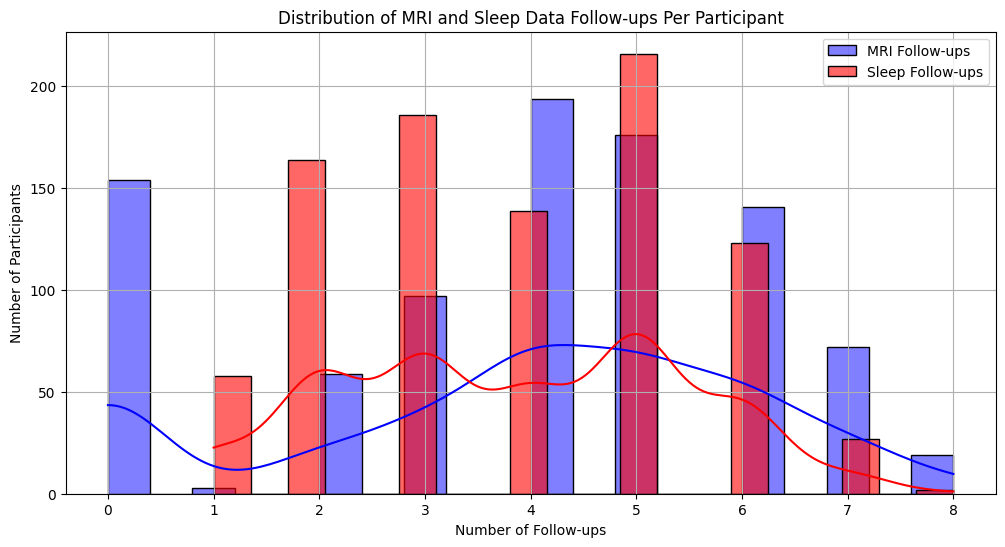

In [92]:
plt.figure(figsize=(12, 6))
sns.histplot(followup_summary["MRI_Followups"], bins=20,
             color="blue", label="MRI Follow-ups", kde=True)
sns.histplot(followup_summary["ADNIMERGE_Followups"], bins=20,
             color="red", label="Sleep Follow-ups", kde=True, alpha=0.6)
plt.xlabel("Number of Follow-ups")
plt.ylabel("Number of Participants")
plt.title("Distribution of MRI and Sleep Data Follow-ups Per Participant")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mri_missing = ucsl_df.isnull().sum() / len(ucsl_df) * 100
print("Percentage of Missing Data in MRI:\n", mri_missing[mri_missing > 0])

sleep_missing = df_merge_ins.isnull().sum() / len(df_merge_ins) * 100
print("\nPercentage of Missing Data in Sleep Questionnaire:\n",
      sleep_missing[sleep_missing > 0])

Percentage of Missing Data in MRI:
 RightNonWMHypoIntensities        100.000000
RightUndetermined                100.000000
RightVessel                        1.316527
RightWMHypoIntensities           100.000000
LeftCorpusCallosum               100.000000
LeftCorpusCallosum               100.000000
LeftCorpusCallosum               100.000000
LeftCorpusCallosum               100.000000
LeftHemisphereWM                 100.000000
LeftInterior                     100.000000
LeftNonWMHypoIntensities         100.000000
LeftUndetermined                 100.000000
LeftVessel                         0.280112
LeftWMHypoIntensities            100.000000
RightCorpusCallosum              100.000000
RightCorpusCallosum              100.000000
RightCorpusCallosum              100.000000
RightCorpusCallosum              100.000000
RightHemisphereWM                100.000000
RightInferiorLateralVentricle      0.028011
FifthVentricle                    46.498599
RightInterior                    100.000